<a name='1'></a>
## Import Packages

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
import tensorflow.keras.layers as tfl
import numpy as np

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "Dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=10)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=10)

Found 980 files belonging to 4 classes.
Using 784 files for training.
Found 980 files belonging to 4 classes.
Using 196 files for validation.


Now let's take a look at some of the images from the training set: 

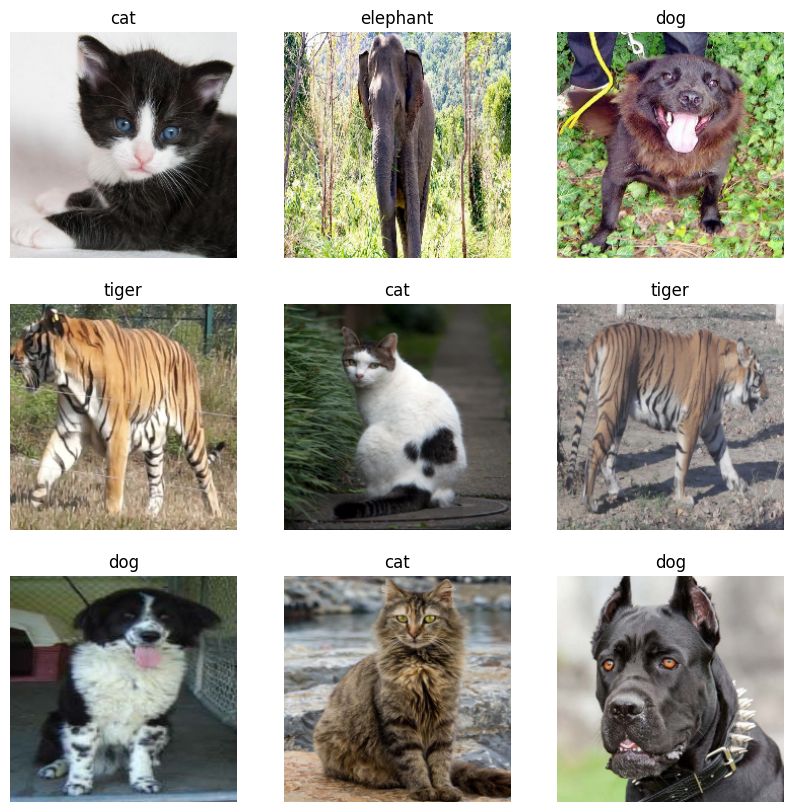

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Now we want implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [7]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    
    return data_augmentation

In [8]:
augmenter = data_augmenter()
augmenter.layers

[<RandomFlip name=random_flip, built=False>,
 <RandomRotation name=random_rotation, built=False>]

Augmenting the data

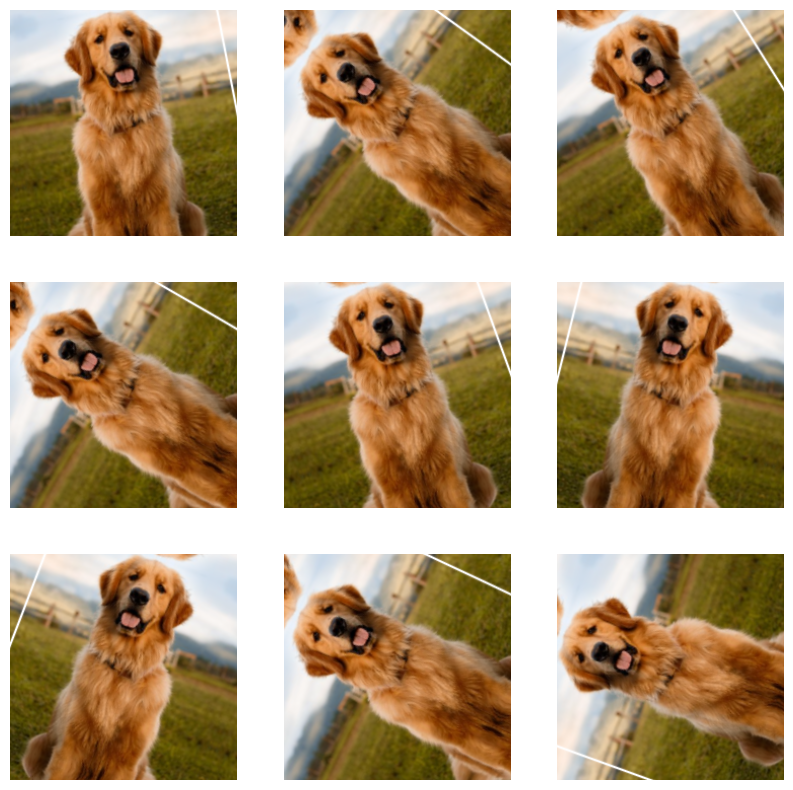

In [14]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [20]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 1, 3, 1, 3, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 3, 1, 1, 1, 0, 0,
       0, 1, 2, 2, 3, 1, 1, 3, 0, 1], dtype=int32)>

In [21]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04209239', 'shower_curtain', 0.67579794),
  ('n03938244', 'pillow', 0.19872838)],
 [('n04209239', 'shower_curtain', 0.99835455),
  ('n03347037', 'fire_screen', 0.0003349932)],
 [('n04209239', 'shower_curtain', 0.95285034),
  ('n03938244', 'pillow', 0.01986314)],
 [('n04209239', 'shower_curtain', 0.48929355),
  ('n03938244', 'pillow', 0.32050455)],
 [('n04209239', 'shower_curtain', 0.9590628),
  ('n03938244', 'pillow', 0.007993165)],
 [('n04209239', 'shower_curtain', 0.07187874),
  ('n03627232', 'knot', 0.058249217)],
 [('n04209239', 'shower_curtain', 0.8273189),
  ('n03938244', 'pillow', 0.09018684)],
 [('n03938244', 'pillow', 0.4356986),
  ('n04209239', 'shower_curtain', 0.39799953)],
 [('n03938244', 'pillow', 0.609353),
  ('n04209239', 'shower_curtain', 0.21011955)],
 [('n04209239', 'shower_curtain', 0.70628184),
  ('n04589890', 'window_screen', 0.059262235)],
 [('n04209239', 'shower_curtain', 0.21949753),
  ('n04589890', 'window_screen', 0.10637073)],
 [('n04209239', 'shower_cu

In [22]:
def classification_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    
    
    input_shape = image_shape + (3,)
    

    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') 
    
    print("Number of layers in the base model: ", len(base_model.layers))
    # freeze the base model by making it non trainable
    base_model.trainable = True 

    # Fine-tune from this layer onwards
    fine_tune_at = 5

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        #print('Layer ' + layer.name + ' frozen.')
        layer.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to True to keeping track of statistics in the batch norm layer
    x = base_model(x) 

    # add the new classification layers
    # use global avg pooling to summarize the info in all channel
    x = tfl.GlobalAveragePooling2D()(x)         
    # create a prediction layer with 4 neuron (as our classifier needs four)
    prediction_layer = tfl.Dense(4)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [23]:
model = classification_model(IMG_SIZE)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Number of layers in the base model:  154


In [24]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 2,227,780 (8.50 MB)

 Non-trainable params: 35,328 (138.00 KB)

In [25]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
initial_epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6440 - loss: 0.8381 - val_accuracy: 0.9796 - val_loss: 0.0455
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9660 - loss: 0.0892 - val_accuracy: 0.9898 - val_loss: 0.0288
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9900 - loss: 0.0359 - val_accuracy: 0.9745 - val_loss: 0.0503
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9871 - loss: 0.0354 - val_accuracy: 0.9898 - val_loss: 0.0279
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.9954 - loss: 0.0270 - val_accuracy: 0.9745 - val_loss: 0.0426
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.9959 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.9929 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9925 - loss: 0.0268 - val_accuracy: 1.0000 - val_l

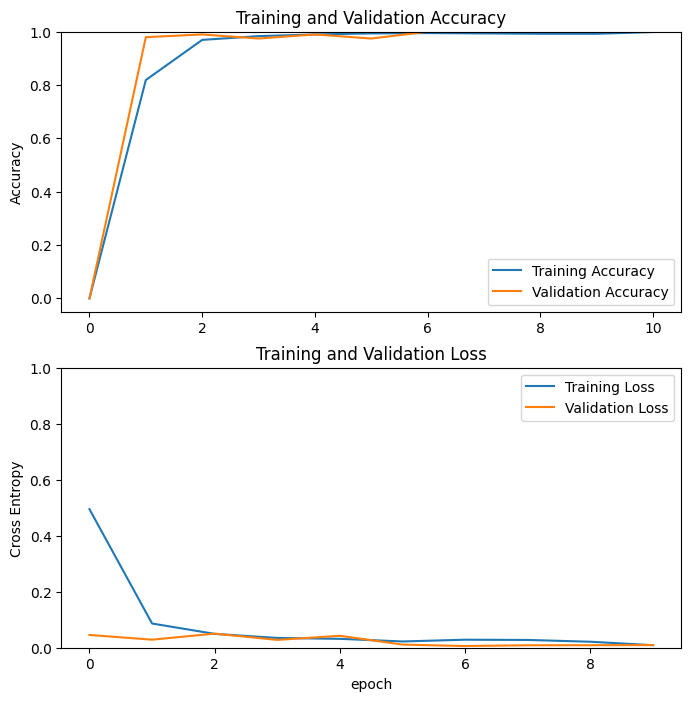

In [27]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# Save the model
model.save('Classify_animals.keras')

In [39]:
import tensorflow as tf
import numpy as np

# Define the target image size
IMG_SIZE = (224, 224)  

# Load the image and resize it to the target size
image = tf.keras.utils.load_img('white.elephant.jpg', target_size=IMG_SIZE)

# Convert the image to an array
img_arr = tf.keras.utils.img_to_array(image)

# Expand the dimensions of the image array to create a batch of size 1
img_bat = tf.expand_dims(img_arr, 0)

# Predict the probabilities for each class
predictions = model.predict(img_bat)

# Calculate the softmax scores
score = tf.nn.softmax(predictions[0])

# Define the categories
data_cat = ['cat', 'dog', 'elephant', 'tiger']

# Determine the predicted class and its corresponding accuracy
predicted_class = data_cat[np.argmax(score)]
accuracy = np.max(score) * 100

# Print the result
print('Animal in image is {} with accuracy of {:0.2f}%'.format(predicted_class, accuracy))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Animal in image is elephant with accuracy of 99.92%


In [41]:
import tensorflow as tf
import numpy as np

# Define the target image size
IMG_SIZE = (224, 224)  

# Load the image and resize it to the target size
image = tf.keras.utils.load_img('dog1.png', target_size=IMG_SIZE)

# Convert the image to an array
img_arr = tf.keras.utils.img_to_array(image)

# Expand the dimensions of the image array to create a batch of size 1
img_bat = tf.expand_dims(img_arr, 0)

# Predict the probabilities for each class
predictions = model.predict(img_bat)

# Calculate the softmax scores
score = tf.nn.softmax(predictions[0])

# Define the categories
data_cat = ['cat', 'dog', 'elephant', 'tiger']

# Determine the predicted class and its corresponding accuracy
predicted_class = data_cat[np.argmax(score)]
accuracy = np.max(score) * 100

# Print the result
print('Animal in image is {} with accuracy of {:0.2f}%'.format(predicted_class, accuracy))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Animal in image is dog with accuracy of 98.69%
